## specifically: stride time (cadence and stride length should be redundant)

In [2]:
import json
from pathlib import Path

import biopsykit as bp
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import seaborn as sns
from biopsykit.questionnaires.utils import compute_scores, wide_to_long
from biopsykit.utils.dataframe_handling import convert_nan
from fau_colors import cmaps, register_fausans_font

from stressgait_analysis.dataset import StressGaitDataset

%matplotlib widget
%load_ext autoreload
%autoreload 2
from stressgait_analysis.gait_helper_functions import compute_HS
import numpy as np
import warnings
warnings.simplefilter(action='ignore')

In [3]:
plt.close("all")

palette = sns.color_palette(cmaps.faculties_light)
sns.set_theme(context="notebook", style="ticks", font="sans-serif", palette=palette)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.family"] = "sans-serif"
#plt.rcParams["font.sans-serif"] = "FAUSans Office"

palette

[(0.37254901960784315, 0.48627450980392156, 0.6392156862745098),
 (0.6666666666666666, 0.7647058823529411, 0.8196078431372549),
 (1.0, 0.8235294117647058, 0.44313725490196076),
 (0.37254901960784315, 0.7725490196078432, 0.9254901960784314),
 (0.5372549019607843, 0.803921568627451, 0.4745098039215686),
 (0.8627450980392157, 0.4117647058823529, 0.48627450980392156)]

In [4]:
deploy_type = "local"

config_dict = json.load(Path("../../config.json").open(encoding="utf-8"))

base_path = Path(config_dict[deploy_type]["base_path"])
gait_data_path = Path(config_dict[deploy_type]["gait_data_path"])

base_path

PosixPath('/home/rzlin/ys64ofuj/Data/StressGait/Data')

In [5]:
dataset = StressGaitDataset(base_path, coarse_condition=True, gait_data_path=gait_data_path, specify_bouts=True, specify_speed=True)

## store as multilevel df

In [6]:
stride_df = dataset.stride_times

In [7]:
mean_stride_time = stride_df.groupby(["participant", "condition"]).mean()

In [8]:
mean_stride_time.groupby(["condition"]).mean()


,stride_time
condition,
control,1.158599
omc,1.188345


In [9]:
mean_stride_time.groupby(["condition"]).std()


,stride_time
condition,
control,0.069125
omc,0.068448


In [10]:
normality_results = mean_stride_time.groupby(['condition'], group_keys=False)["stride_time"].apply(
    lambda g: pg.normality(g))
normality_results


,W,pval,normal
control,0.929832,0.153271,True
omc,0.944561,0.291953,True


In [11]:
test_results = pg.pairwise_tests(data=mean_stride_time.reset_index(),
                                 dv='stride_time',
                                 between='condition',
                                 parametric=True)
test_results["p_corr"] = test_results["p-unc"] * 2
test_results["p_corr"].clip(upper=1, inplace=True)
test_results

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges,p_corr
0,condition,control,omc,False,True,-1.367505,38.0,two-sided,0.179501,0.645,-0.423852,0.359003


<Axes: xlabel='condition', ylabel='stride_time'>

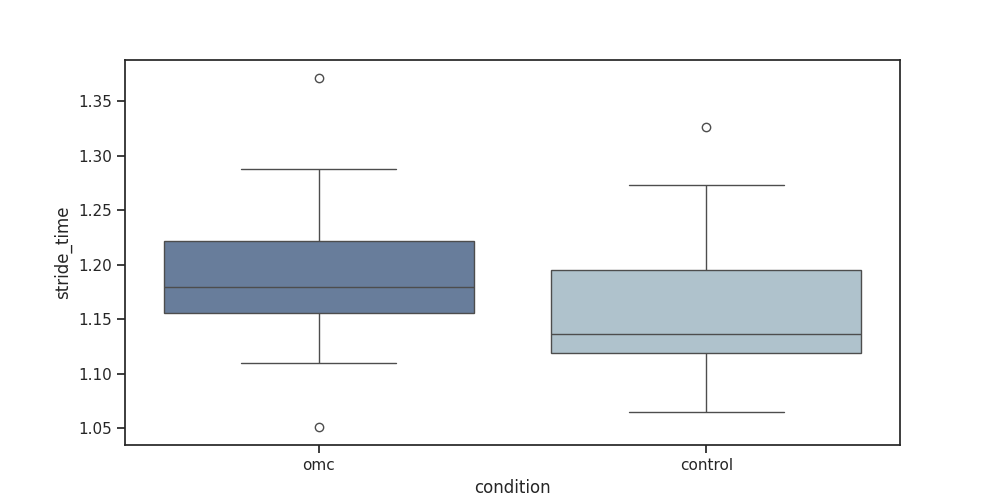

In [12]:
plt.figure()
sns.boxplot(data=mean_stride_time, x="condition", y="stride_time", hue="condition")